In [1]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression

plt.style.use({'figure.facecolor':'white'})

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [24]:
model_path_1 = './model/ising_init_0110/gnn1.pth'
model_path_2 = './model/ising_init_0110/mlp1.pth'
model_path_3 = './model/ising_init_0110/ols_full.pk'
model_path_4 = './model/ising_init_0110/ols.pk'
model_path_5 = './model/ising_init_0110/rfr_list.pk'

In [25]:
models = []

model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

model_2 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))

with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

with open(model_path_4, 'rb') as f:
    model_4 = pickle.load(f)
models.append((model_4, 'ols'))

with open(model_path_5, 'rb') as f:
    model_5 = pickle.load(f)
models.append((model_5, 'rfr_list'))

In [55]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [63]:
test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/ising_init_0110/val', '.pk')
print(len(test_circuits))

100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

1500


In [64]:
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]

In [65]:
df = []

for i, (circ, ideal_exp_val, noisy_exp_val) in tqdm(enumerate(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals))):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val

    circ_trans = transpile(circ, backend, optimization_level=3)
    graph_data = circuit_to_graph_data_json(
                circuit=circ_trans,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
    entry = ExpValueEntry(
        circuit_graph=graph_data,
        observable=[],
        ideal_exp_value=ideal_exp_val,
        noisy_exp_values=[noisy_exp_val],
        circuit_depth=circ_trans.depth()
    ).to_pyg_data()

    X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

    for j, (model, m_type) in enumerate(models):
        if m_type == 'mlp':
            row[f'model_{j}'] = model(X).tolist()[0]
        elif m_type == 'gnn':
            row[f'model_{j}'] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif m_type in ['ols_full', 'rfr_full']:
            row[f'model_{j}'] = model.predict(X).tolist()[0]
        elif m_type in ['ols', 'rfr']:
            row[f'model_{j}'] = model.predict(X[:, -4:]).tolist()[0]
        else:
            raise NotImplementedError

    df.append(row)

df = pd.DataFrame(df)

1500it [03:08,  7.94it/s]


In [69]:
df

In [70]:
plt.figure()
plt.style.use({'figure.facecolor':'white'})
q = 3
dist_noisy = df['noisy'].apply(lambda x: x[q]) - df['ideal'].apply(lambda x: x[q])
sns.histplot(dist_noisy, kde=True, alpha=0.2, label='dist_noisy')
for i in range(len(models)):
    dist_model = df['noisy'].apply(lambda x: x[q]) - df[f'model_{i}'].apply(lambda x: x[q])
    sns.histplot(dist_model, kde=True, alpha=0.2, label=f'dist_{models[i][1]}')

plt.xlabel("Distance")
plt.ylabel("Counts")
plt.title(f"Distribution of distance to ideal on q{q}")
plt.xlim([-0.35, 0.15])
plt.ylim([0, 300])
plt.legend()
plt.show()
# Plot the distribution
# sns.histplot(dist_noisy, kde=True)
# plt.xlabel("Differences (Column2 - Column1)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Differences between First Entries of Column2 and Column1")
# plt.show()

,ideal,noisy,model_0,model_1,model_2,model_3,model_4
0,"[0.2424, 0.1364, -0.1016, -0.129]","[0.0216, -0.0012, -0.0494, -0.0776]","[0.06626548618078232, 0.039129436016082764, -0...","[0.1296897530555725, 0.055851344019174576, -0....","[0.0305938720703125, 0.034912109375, -0.029464...","[0.049465131014585495, 0.021362297236919403, 0...","[0.18049666424592337, 0.025792000258225017, -0..."
1,"[0.2064, 0.1556, -0.1128, -0.1228]","[-0.001, 0.0202, -0.0556, -0.055]","[0.042641423642635345, 0.05746396631002426, -0...","[0.060594066977500916, 0.0967818945646286, -0....","[0.0324554443359375, 0.06608772277832031, -0.1...","[0.022807886824011803, 0.044343817979097366, -...","[0.07596666707036395, 0.0805580011914329, -0.1..."
2,"[-0.0428, 0.0314, 0.0818, 0.0468]","[-0.0294, 0.0206, -0.0142, -0.071]","[0.007010269910097122, 0.053372785449028015, -...","[-0.008263474330306053, 0.06418350338935852, 0...","[-0.03989410400390625, 0.053028106689453125, -...","[-0.020956747233867645, 0.04445544630289078, 0...","[-0.03031599998784562, 0.038208666293649, 0.06..."
3,"[-0.1934, 0.1128, -0.5022, -0.1258]","[-0.0916, 0.002, -0.1398, -0.0962]","[-0.06851490586996078, 0.03460923954844475, -0...","[-0.1786912977695465, 0.08997806906700134, -0....","[-0.1461334228515625, -0.011426925659179688, -...","[-0.092185840010643, 0.014375774189829826, -0....","[-0.19825466667612393, 0.09938066762095939, -0..."
4,"[-0.0946, 0.0508, 0.1118, 0.0098]","[-0.042, 0.019, -0.0254, -0.0928]","[-0.010268477723002434, 0.05230247229337692, -...","[-0.03131217509508133, 0.08020511269569397, 0....","[-0.0571136474609375, 0.05134010314941406, -0....","[-0.04019463062286377, 0.042926739901304245, 0...","[-0.048524667133266725, 0.038621333041616406, ..."
...,...,...,...,...,...,...,...
1495,"[0.473, 0.3098, -0.5124, -0.0176]","[0.3532, 0.1066, -0.2358, -0.1238]","[0.45320606231689453, 0.19614779949188232, -0....","[0.4689521789550781, 0.3059275150299072, -0.47...","[0.481231689453125, 0.1994495391845703, -0.220...","[0.47484320402145386, 0.1907276213169098, -0.1...","[0.4688153262933095, 0.29633133361736935, -0.5..."
1496,"[-0.0794, 0.0548, -0.1158, -0.0118]","[-0.083, 0.0344, -0.065, -0.0384]","[-0.05445551872253418, 0.05003618448972702, -0...","[-0.11589954048395157, 0.05884004756808281, -0...","[-0.0753173828125, 0.06559944152832031, -0.165...","[-0.08066880702972412, 0.052936434745788574, -...","[-0.10758333331594865, 0.06086599984865946, -0..."
1497,"[0.0436, -0.0916, 0.2186, 0.0792]","[-0.0478, -0.078, -0.0266, -0.1124]","[-0.023869765922427177, -0.061002135276794434,...","[-0.015635913237929344, -0.12142059206962585, ...","[-0.05393218994140625, -0.07972145080566406, 0...","[-0.04053020477294922, -0.07962989062070847, 0...","[-0.031072666486919236, -0.1111586665858825, 0..."
1498,"[-0.0054, -0.0964, 0.2452, 0.0696]","[-0.0846, -0.0822, -0.0004, -0.1016]","[-0.06636255234479904, -0.07231906801462173, 0...","[-0.0649692639708519, -0.13771213591098785, 0....","[-0.10323333740234375, -0.08916854858398438, 0...","[-0.08803550153970718, -0.08891383558511734, 0...","[-0.09338799967032779, -0.12864266730844975, 0..."


In [6]:
from qiskit import *
from typing import TypedDict

import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value, Counts
from typing import Union, List, Dict

class CountsProcess:

    @classmethod
    def pauli_exp_val_all1Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                # In the string representation qubit-0 corresponds to the right-most Pauli character
                pauli = SparsePauliOp.from_sparse_list([("Z", [n], 1)], nq)
                expect = sampled_expectation_value(counts, pauli)
                if nolabels:
                    expects += [expect]
                else:
                    expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all1Q_for_counts(count)
                expects += [expect]
            return expects

    @classmethod
    def pauli_exp_val_all2Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                for m in range(n+1, nq):
                    # In the string representation qubit-0 corresponds to the right-most Pauli character
                    pauli = SparsePauliOp.from_sparse_list([("ZZ", [n,m], 1)], nq)
                    expect = sampled_expectation_value(counts, pauli)
                    if nolabels:
                        expects += [expect]
                    else:
                        expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all2Q_for_counts(count)
                expects += [expect]
            return expects


class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, sweep_steps = None, measure_bases = None):
        sweep_steps = sweep_steps or [16]
        measure_bases = measure_bases or ['Z']

        circs = []
        run_params = []
        for basis in measure_bases:
            for depth in range(*sweep_steps):
                ops['measure_basis'] = basis
                ops['depth'] = depth
                qc = cls.make_quantum_circuit(ops)
                qc.metadata = {}
                qc.metadata['measure_basis'] = basis
                qc.metadata['depth'] = depth
                run_params += [qc.metadata.copy()]
                circs += [qc]
        return circs, run_params

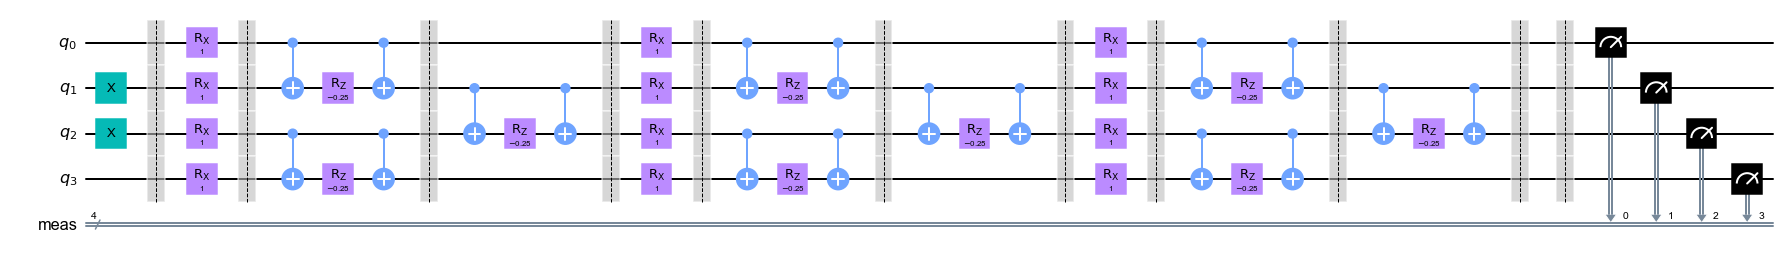

In [20]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def generate_random_initial_state():
    qc = QuantumCircuit(4)
    random_state = random_statevector(2**4).data
    qc.initialize(random_state, list(range(4)))
    return qc

def generate_random_initial_num_gate(num_gates=2):
    qr = QuantumRegister(4, 'q')
    qc = QuantumCircuit(qr)

    for _ in range(num_gates):
        gate_type = np.random.choice(['rx', 'rz', 'cnot'])
        qubit_indices = np.random.choice(range(4), size=2, replace=False)

        if gate_type == 'ry':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RYGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rx':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rz':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RZGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'id':
            pass
        elif gate_type == 'cnot':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
            qc.append(CXGate(), [qr[qubit_indices[0]], qr[qubit_indices[1]]])

    return qc

def construct_ising_circuit_random_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    # qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    qc_init = QuantumCircuit(4)
    # qc_init.initialize(random_statevector(2**4).data, qc_init.qubits)
    qc_init.x(1)
    qc_init.x(2)
    qc_init.barrier()
    max_step = 30
    qc_list = []
    for i in range(max_step):
        qc_list.append(qc_init.compose(cls.make_circs_sweep(ops, sweep_steps=[max_step], measure_bases=['Z'])[0][i], list(range(4))))
    return qc_list

np.random.seed(5)
J = 0.25
basis = np.random.choice(list('XYZ'))
random_ising = construct_ising_circuit_random_init(J, basis, 2)
qc_list = transpile(random_ising, backend=backend_ideal, optimization_level=3)
qc_list[3].draw('mpl', fold=-1)

In [ ]:
np.random.seed(1)
qc_init = generate_random_initial_num_gate(5)
qc_init.qasm()

In [148]:
# cls = IsingModel
# ops = cls.Options()
# ops.config_4q_paper()
# # ops.config_10q_paper()
# qc_list, run_params = cls.make_circs_sweep(ops, sweep_steps=[15], measure_bases=['Z'])
# qc_list[1].draw('mpl', fold=-1)

In [26]:
from tqdm import tqdm

fix_random_seed(0)

num_traj = 1

def run_ising_steps(be, r_c_n):
    exp_Z_all_ideal = []
    exp_Z_all_noisy = []
    exp_Z_all_mitigated_dict = defaultdict(list)

    for _ in tqdm(range(num_traj)):

        transpiled_qc_list = transpile(qc_list, be, optimization_level=3)
        job_ideal = execute(qc_list, **run_config_ideal)
        job_noisy = execute(transpiled_qc_list, **r_c_n)

        exp_Z_ideal = []
        exp_Z_noisy = []
        exp_Z_mitigated_dict = defaultdict(list)

        for i in range(len(qc_list)):
            counts_ideal = job_ideal.result().get_counts()[i]
            counts_noisy = job_noisy.result().get_counts()[i]

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            exp_Z_ideal.append(list(ideal_exp_val))  # Single-Z expectation value of each qubit
            exp_Z_noisy.append(list(noisy_exp_val))  # Single-Z expectation value of each qubit

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled_qc_list[i],
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=transpiled_qc_list[i].depth()
            ).to_pyg_data()

            X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

            for j, (model, mtype) in enumerate(models):
                if mtype == 'mlp':
                    mitigated_exp_val = model(X).tolist()[0]
                elif mtype == 'gnn':
                    mitigated_exp_val = model(entry.noisy_0,
                                            entry.observable,
                                            entry.circuit_depth,
                                            entry.x,
                                            entry.edge_index,
                                            entry.batch).tolist()[0]
                elif mtype in ['ols_full', 'rfr_full']:
                    mitigated_exp_val = model.predict(X).tolist()[0]
                elif mtype in ['ols', 'rfr']:
                    mitigated_exp_val = model.predict(X[:, -4:]).tolist()[0]
                elif mtype in ['rfr_list']:
                    mitigated_exp_val = []
                    for q, m in enumerate(model):
                        mitigated_exp_val.append(m.predict(X))
                    mitigated_exp_val = np.array(mitigated_exp_val).transpose()
                else:
                    raise NotImplementedError

                exp_Z_mitigated_dict[j].append(mitigated_exp_val)

        exp_Z_all_ideal.append(exp_Z_ideal)
        exp_Z_all_noisy.append(exp_Z_noisy)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            exp_Z_all_mitigated_dict[k].append(exp_Z_mitigated)

    return exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict


######################## Need to change ##############################
exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict = run_ising_steps(backend_noisy, run_config_noisy)
######################## Need to change ##############################

random seed fixed to 0


100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


In [27]:
exp_Z_all_ideal = np.array(exp_Z_all_ideal).squeeze()
exp_Z_all_noisy = np.array(exp_Z_all_noisy).squeeze()
for key, val in exp_Z_all_mitigated_dict.items():
    exp_Z_all_mitigated_dict[key] = np.array(val).squeeze()

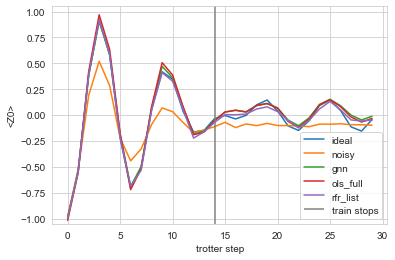

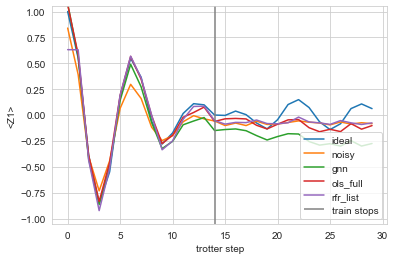

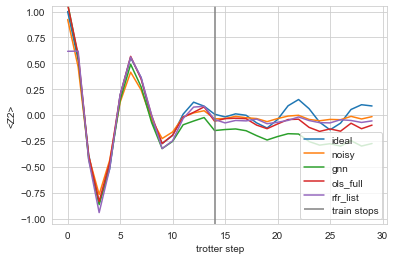

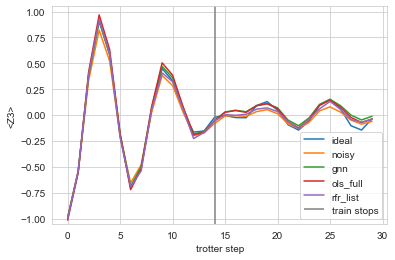

In [28]:
for q in range(4):
    plt.style.use({'figure.facecolor':'white'})
    plt.plot(exp_Z_all_ideal[:, q], label='ideal')
    plt.plot(exp_Z_all_noisy[:, q], label='noisy')
    for key, val in exp_Z_all_mitigated_dict.items():
        if models[key][1] in [
            'gnn',
            # 'mlp',
            'ols_full',
            'rfr_list'
        ]:
            plt.plot(val[:, q], label=f'{models[key][1]}')
    plt.ylim([-1.05, 1.05])
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim([ymin, ymax])
    plt.vlines(x=14, ymin=ymin, ymax=ymax, color='gray', label = 'train stops')
    plt.legend(loc='lower right')
    plt.ylabel(f'<Z{q}>')
    plt.xlabel('trotter step')
    plt.show()